In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sn

from scipy.stats import norm
from sklearn.covariance import empirical_covariance
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
training_path = Path().resolve().parents[0] / 'data' / 'clean_training_data.csv'

In [3]:
df = pd.read_csv(training_path)

In [4]:
df.head()

,Unnamed: 0,original_text,label,text_length,complexity_scores,token_count,stopword_count,sum_cs,avg_cs
0,0,There is manuscript evidence that Austen conti...,1,43,"[13, 11, 30, 11, 8, 7, 15, 2, 17.89, 3, 3, 38,...",18,25,360.89,20.049444
1,1,"In a remarkable comparative analysis , Mandaea...",1,23,"[8, 14, 28, 52, 4, 10, 17.89, 38, 29, 5, 12, 5...",13,10,278.89,21.453077
2,2,"Before Persephone was released to Hermes , who...",1,37,"[17.89, 7, 17.89, 14, 9, 17.89, 3, 6, 34, 3, 2...",15,22,181.67,12.111333
3,3,Cogeneration plants are commonly found in dist...,1,39,"[17.89, 26, 4, 11, 14, 19, 40, 26, 19, 11, 15,...",27,12,441.89,16.366296
4,4,Geneva is the second-most-populous city in Swi...,1,16,"[48, 26, 24, 4, 26, 17.89]",6,10,145.89,24.315000


In [5]:
df = df.dropna()

In [6]:
df_X = df.drop(['original_text','Unnamed: 0','label','complexity_scores'], axis=1)
df_y = df['label']

In [7]:
df_X.head()

,text_length,token_count,stopword_count,sum_cs,avg_cs
0,43,18,25,360.89,20.049444
1,23,13,10,278.89,21.453077
2,37,15,22,181.67,12.111333
3,39,27,12,441.89,16.366296
4,16,6,10,145.89,24.315000


In [8]:
df_X_normalized = StandardScaler().fit_transform(df_X)

In [9]:
pca = PCA(n_components=2).fit(df_X_normalized)
X_pca = pca.transform(df_X_normalized)
print(df_X_normalized.shape, X_pca.shape)

(415211, 5) (415211, 2)


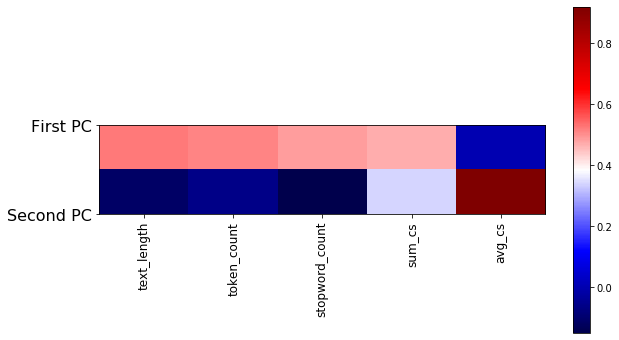

In [10]:
#Plotting feature importance, pulled from pca.components_
#The larger the importance value, the more a feature contributes to that PC
def plot_pca(pca, top_k = 2):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(pca.components_[0:top_k], interpolation = 'none', cmap = 'seismic')
    feature_names=list(df_X.columns)
    plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
    plt.yticks(np.arange(0., 2, 1), ['First PC', 'Second PC'], fontsize = 16)
    plt.colorbar()
    
plot_pca(pca)

In [11]:
# features = list(df_X.columns)
# labels = {
#     str(i): f"PC {i+1} ({var:.1f}%)"
#     for i, var in enumerate(pca.explained_variance_ratio_ * 100)
# }

# fig = px.scatter_matrix(
#     X_pca,
#     labels=labels,
#     dimensions=range(2),
#     color=df_y)

# fig.update_traces(diagonal_visible=False)

explained_variance_ratio: [0.70733701 0.23060268]
sum of explained variance ratios: 0.937939694887484
singular values: [1211.80466242  691.91318343]
[3.53669358 1.15301619]
415211


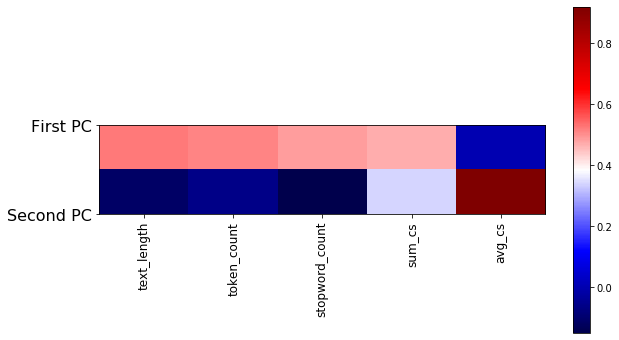

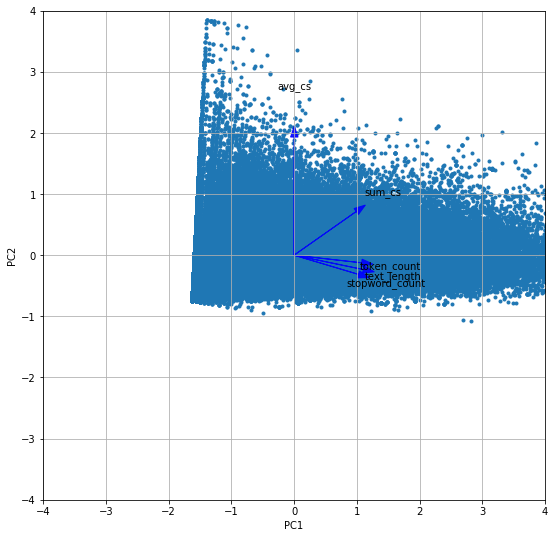

In [12]:
feature_subset_count = 5
pca = PCA(n_components = 2).fit(df_X_normalized)
X_pca = pca.transform(df_X_normalized)
plot_pca(pca)
feature_names=list(df_X.columns)

#Biplot example code pulled from SIADS 543
def biplot(score, coeff, maxdim, pcax, pcay, labels=None):
    zoom = 4
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n = min(coeff.shape[0], maxdim)
    width = 2.0 * zoom
    scalex = width/(xs.max()- xs.min())
    scaley = width/(ys.max()- ys.min())
    text_scale_factor = 3
        
    fig = plt.gcf()
    fig.set_size_inches(9, 9)
    
    plt.scatter(xs*scalex, ys*scaley, s=9)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1]*text_scale_factor*0.7, coeff[i,pca2]*text_scale_factor*0.7,
                  color='b',alpha=0.9, head_width = 0.03 * zoom) 
        if labels is None:
            plt.text(coeff[i,pca1]* text_scale_factor, 
                     coeff[i,pca2] * text_scale_factor, 
                     "Var"+str(i+1), color='k', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* text_scale_factor, 
                     coeff[i,pca2] * text_scale_factor, 
                     labels[i], color='k', ha='center', va='center')
    
    plt.xlim(-zoom,zoom)
    plt.ylim(-zoom,zoom)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

plt.figure()

feature_subset = slice(0, feature_subset_count, 1)

biplot(X_pca, np.transpose(pca.components_[0:2, feature_subset]), 
       feature_subset_count, 1, 2, labels=feature_names[feature_subset])

print("explained_variance_ratio:", pca.explained_variance_ratio_)
print("sum of explained variance ratios:", np.sum(pca.explained_variance_ratio_))
print("singular values:", pca.singular_values_)  

# The variances of the PCs are given by the squares of the singular values of X*, divided by n−1. 
# Since they are the eigenvalues of the (n-1)S matrix where S is the correlation matrix of X
print(np.power(pca.singular_values_, 2) / (df_X_normalized.shape[0] - 1))
print(df_X_normalized.shape[0])

In [13]:
#Playing with opacity to see if complex labels are edges or throughout

#fig = px.scatter(X_pca, x=0, y=1, color=df_y, color_continuous_scale=['#ffffff','#3264a8'], opacity=0.1)
#fig.show()



In [14]:
pca = PCA(n_components=2).fit(df_X_normalized)
X_pca = pca.transform(df_X_normalized)

# labels = {
#     str(i): f"PC {i+1} ({var:.1f}%)"
#     for i, var in enumerate(pca.explained_variance_ratio_ * 100)
# }

# fig = px.scatter_matrix(
#     X_pca,
#     labels=labels,
#     dimensions=range(5),
#     color=df_y)

# fig.update_traces(diagonal_visible=False)

In [16]:
# df_var = pd.DataFrame({'explained var ratio':pca.explained_variance_ratio_,
#                    'PC':['PC1','PC2','PC3','PC4','PC5']})
# sn.barplot(x = 'PC',y = "explained var ratio", data = df_var, color="c");
# np.cumsum(df_var['explained var ratio'])

# Kernel PCA Attempt

In [17]:
# from sklearn.decomposition import KernelPCA

# kpca = KernelPCA(kernel='rbf', gamma=5).fit(df_X_normalized[:10000])
# X_kpca = kpca.transform(df_X_normalized[:10000])

In [18]:
# fig = px.scatter(X_kpca, x=0, y=1, color=df_y[:10000], color_continuous_scale=['#04f500','#8f00f5'], opacity=1)
# fig.show()

KPCA takes too much memory, not going to work :(

# KMeans

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

In [20]:
X_kmeans = df_X.values
y_means = df_y

X_kmeans_normalized = StandardScaler().fit(X_kmeans).transform(X_kmeans)

#X_kmeans_normalized

#kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1)
#kmeans.fit(X_kmeans)

#labels = kmeans.labels_

#calinski_harabasz_score(X_kmeans, labels), davies_bouldin_score(X_kmeans, labels)

### Calinski-Harabasz and Davies-Bouldin

In [21]:
clusters = list(range(2,6))

calinski_scores = []
davies_scores = []

for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, init='k-means++', max_iter=100, n_init=1)
    kmeans.fit(X_kmeans_normalized)
    
    labels = kmeans.labels_
    
    calinski_scores.append((cluster, calinski_harabasz_score(X_kmeans, labels)))
    davies_scores.append((cluster, davies_bouldin_score(X_kmeans, labels)))
    
#print(calinski_scores)
#print(davies_scores)

Text(0, 0.5, 'Calinski-Harabasz Scores')

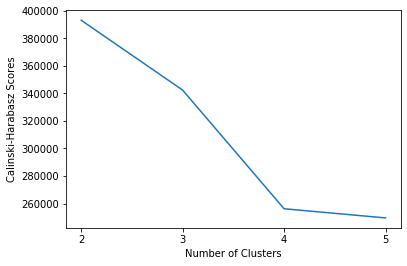

In [31]:
#Chart of Calinski scores (higher is better)
plt.plot(*zip(*calinski_scores))
plt.xlabel('Number of Clusters')
plt.xticks(ticks=[2,3,4,5])
plt.ylabel('Calinski-Harabasz Scores')

Text(0, 0.5, 'Davies-Bouldin Score')

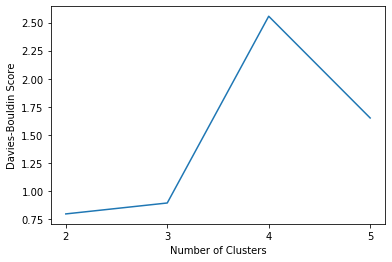

In [30]:
#Chart of Davies scores (lower is better)
plt.plot(*zip(*davies_scores))
plt.xlabel('Number of Clusters')
plt.xticks(ticks=[2,3,4,5])
plt.ylabel('Davies-Bouldin Score')

Text(0, 0.5, 'PCA 2')

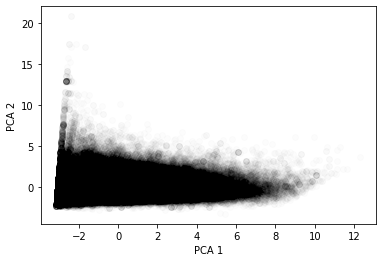

In [28]:
kmeans_test = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1)
kmeans_test.fit(X_pca)

PCA_components = pd.DataFrame(X_pca, columns=['PCA1','PCA2'])

plt.scatter(PCA_components['PCA1'], PCA_components['PCA2'], alpha=0.01, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# fig = px.scatter(X_pca, x=0, y=1, color=kmeans_test.labels_, color_continuous_scale=['#04f500','#8f00f5'], opacity=1)
# fig.show()

#Find better KMeans vis!
#3D mapping with tokens, cs_sum, cs_mean?


In [33]:
from tqdm import tqdm

SSE = []
for cluster in tqdm(range(1,10)):
    kmeans = KMeans(n_clusters=cluster, init='k-means++')
    kmeans.fit(X_kmeans_normalized)
    SSE.append(kmeans.inertia_)


100%|██████████| 9/9 [05:12<00:00, 34.74s/it]


Text(0, 0.5, 'Inertia')

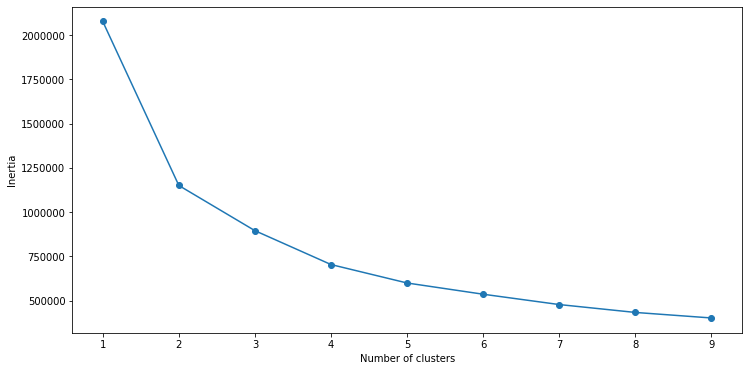

In [34]:
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'],frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
from sklearn.metrics import silhouette_score